# LSOA Sketches

Sketches around crime data at LSOA level.

The notebook looks complicated but there are actually very few steps (it's just the output that is noisy: run `Cell->All Outpu->Clear` to see the raw steps), and these could be hidden behind more general functions to give simple one-liners that call multiple steps.

## Looking Up LSOAs

If the data is keyed by LSOA code, we can search on that directly. But sometimes we may just have a postcode or latitude and longitude, in which case we need to lookup the LSOA from the postcode or latitude-longitude.

First, let's focus on how to lookup a lat/lon within a set of LSOA boundaries in order to discover the LSOA code.

Postcode lookups will be dealt with in a following section.

In [12]:
#Some set up stuff

#Database filename
db='adminboundaries.db'

#Database table for LSOA shapefiles
table='lsoa'
#LSOA shapefile projection
projection='27700'


### Getting Boundary files

Data from ONS: http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-full-clipped-boundaries-in-england-and-wales

In [2]:
#From download menu, copy link for shapefile
#-O swithc outputs to named file: lsoa.zip
!wget https://opendata.arcgis.com/datasets/da831f80764346889837c72508f046fa_0.zip?outSR=%7B%22wkid%22%3A27700%2C%22latestWkid%22%3A27700%7D -O lsoa.zip 
#Note that the projection at the end of the URL appears to be 27700

--2019-03-07 09:34:34--  https://opendata.arcgis.com/datasets/da831f80764346889837c72508f046fa_0.zip?outSR=%7B%22wkid%22%3A27700%2C%22latestWkid%22%3A27700%7D
Resolving opendata.arcgis.com (opendata.arcgis.com)... 52.7.213.26, 34.197.13.10
Connecting to opendata.arcgis.com (opendata.arcgis.com)|52.7.213.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘lsoa.zip’

lsoa.zip                [         <=>        ] 223.31M  42.2MB/s    in 5.2s    

2019-03-07 09:34:40 (43.3 MB/s) - ‘lsoa.zip’ saved [234156285]



In [3]:
!unzip lsoa.zip

Archive:  lsoa.zip
 extracting: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.cpg  
  inflating: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.shx  
  inflating: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.prj  
  inflating: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.xml  
  inflating: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.shp  
  inflating: Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.dbf  


In [3]:
path='./Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales'

In [19]:
! spatialite adminboundaries.db ".loadshp $path $table UTF-8 $projection"

SpatiaLite version ..: 4.3.0a	Supported Extensions:
	- 'VirtualShape'	[direct Shapefile access]
	- 'VirtualDbf'		[direct DBF access]
	- 'VirtualXL'		[direct XLS access]
	- 'VirtualText'		[direct CSV/TXT access]
	- 'VirtualNetwork'	[Dijkstra shortest path]
	- 'RTree'		[Spatial Index - R*Tree]
	- 'MbrCache'		[Spatial Index - MBR cache]
	- 'VirtualSpatialIndex'	[R*Tree metahandler]
	- 'VirtualElementary'	[ElemGeoms metahandler]
	- 'VirtualXPath'	[XML Path Language - XPath]
	- 'VirtualFDO'		[FDO-OGR interoperability]
	- 'VirtualGPKG'	[OGC GeoPackage interoperability]
	- 'VirtualBBox'		[BoundingBox tables]
	- 'SpatiaLite'		[Spatial SQL - OGC]
PROJ.4 version ......: Rel. 4.9.3, 15 August 2016
GEOS version ........: 3.6.2-CAPI-1.10.2 4d2925d6
TARGET CPU ..........: x86_64-linux-gnu
the SPATIAL_REF_SYS table already contains some row(s)
Loading shapefile at './Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales' into SQLite table 'lsoa'

BEGIN;
CREATE TAB

In [24]:
#Create an index
! spatialite adminboundaries.db '''SELECT CreateSpatialIndex('$table', 'Geometry');'''


SpatiaLite version ..: 4.3.0a	Supported Extensions:
	- 'VirtualShape'	[direct Shapefile access]
	- 'VirtualDbf'		[direct DBF access]
	- 'VirtualXL'		[direct XLS access]
	- 'VirtualText'		[direct CSV/TXT access]
	- 'VirtualNetwork'	[Dijkstra shortest path]
	- 'RTree'		[Spatial Index - R*Tree]
	- 'MbrCache'		[Spatial Index - MBR cache]
	- 'VirtualSpatialIndex'	[R*Tree metahandler]
	- 'VirtualElementary'	[ElemGeoms metahandler]
	- 'VirtualXPath'	[XML Path Language - XPath]
	- 'VirtualFDO'		[FDO-OGR interoperability]
	- 'VirtualGPKG'	[OGC GeoPackage interoperability]
	- 'VirtualBBox'		[BoundingBox tables]
	- 'SpatiaLite'		[Spatial SQL - OGC]
PROJ.4 version ......: Rel. 4.9.3, 15 August 2016
GEOS version ........: 3.6.2-CAPI-1.10.2 4d2925d6
TARGET CPU ..........: x86_64-linux-gnu
Error: no such column: lsoa


### SQlite lookups

How to lookup data from the spatialite database.

In [13]:
#Set up the db connection and load in the spatialite extension
import sqlite3
import pandas as pd

#!whereis mod_spatialite.so
shared_lib = '/usr/lib/x86_64-linux-gnu/mod_spatialite.so'

# Create connection and load spatialite extension
conn = sqlite3.connect(db)

# Enable SpatialLite extension
conn.enable_load_extension(True)
conn.load_extension(shared_lib)

# Initialise spatial table support
conn.execute('SELECT InitSpatialMetadata(1)')

In [27]:
#We can make a simple pandas query
pd.read_sql('SELECT * FROM lsoa LIMIT 3', conn)

,PK_UID,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,Geometry
0,1,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,b'\x00\x014l\x00\x008\x89A`\xc1; A@\x89A`t \x0...
1,2,2,E01000002,City of London 001B,City of London 001B,228419.333117,2708.052040,b'\x00\x014l\x00\x00\xa8\x9b\xc4 \xea= A\x00\x...
2,3,3,E01000003,City of London 001C,City of London 001C,59054.013119,1224.770897,b'\x00\x014l\x00\x008\x89A`\xb1< A\x00\x00\x00...


In [8]:
import geopandas as gpd
%matplotlib inline

def gpd_sql(q):
    ''' Add ",{geo}" in SELECT part of query and this will insert required element. "'''
    q = q.format(geo="Hex(ST_AsBinary(Geometry)) AS Geometry")
    return gpd.GeoDataFrame.from_postgis(q, conn, geom_col='Geometry')

In [9]:
q = "SELECT lsoa11cd, lsoa11nm, {geo} FROM lsoa LIMIT 2;"
gpd_sql(q).head()

,lsoa11cd,lsoa11nm,Geometry
0,E01000001,City of London 001A,(POLYGON ((532095.5630000001 181577.3509999998...
1,E01000002,City of London 001B,(POLYGON ((532267.7280000001 181643.7809999995...


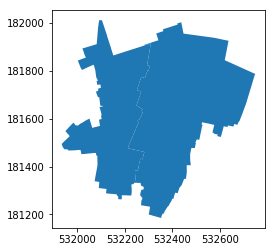

In [11]:
gpd_sql(q).plot()

### Lookup LSOA From Lat/Long

Given a lat-long pair such as `52.0246, -0.7107`, how can we find it's LSOA from the shapefile data?

The first thing we need to do is make the co-ordinates a shapey geometrical thing:

### Utilities

The shapefile we downloaded from the ONS uses the OSGB projection. To look up lat/long values we have to either project the shapefile onto the latlon projection, or the latlon into the OSGB projection. We can do this transformation ourselves:

In [41]:
from pyproj import Proj, transform

def latlongToOSGB(lat, lon):
    ''' Simple function to transform from lat/long to OSGB. '''
    
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:27700')
    return transform(inProj,outProj, lon, lat)


In [64]:
lat, lon = 52.0246, -0.7107

easting, northing = latlongToOSGB(lat, lon)
easting, northing

(488560.26469329005, 237026.9629462888)

In [67]:
q="SELECT lsoa11cd, lsoa11nm FROM lsoa WHERE Within(ST_PointFromText('POINT({e} {n})'), Geometry)".format(e=easting,n=northing)
pd.read_sql(q, conn)

,lsoa11cd,lsoa11nm
0,E01016820,Milton Keynes 017C


Alternatively, we can do the translation within the spatialite query itself:

In [80]:
q="SELECT lsoa11cd, lsoa11nm FROM lsoa WHERE Within(ST_Transform(ST_GeomFromText('POINT({lon} {lat})',4326),27700), Geometry)".format(lat=lat,lon=lon)
pd.read_sql(q, conn)

,lsoa11cd,lsoa11nm
0,E01016820,Milton Keynes 017C
